In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -u "/content/drive/MyDrive/CS 189/hw5.zip" -d /content
## Locate this notebook inside data
%cd /content/hw5

Mounted at /content/drive
Archive:  /content/drive/MyDrive/CS 189/hw5.zip
   creating: /content/hw5/
   creating: /content/hw5/datasets/
  inflating: /content/hw5/decision_tree_starter.py  
  inflating: /content/hw5/hw5.pdf    
   creating: /content/hw5/datasets/titanic/
   creating: /content/hw5/datasets/spam_data/
  inflating: /content/hw5/datasets/titanic/titanic_training.csv  
  inflating: /content/hw5/datasets/titanic/titanic_testing_data.csv  
  inflating: /content/hw5/datasets/spam_data/spam_data.mat  
/content/hw5


In [2]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split

In [3]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        # TODO
        for col in range(data.shape[1]):
            if col not in onehot_cols:  # Skip one-hot encoded columns
                # Calculate mode for each column
                unique, counts = np.unique(data[:, col][data[:, col] != -1], return_counts=True)
                if len(unique) > 0:  # Check if there are non-missing values
                    mode_value = unique[np.argmax(counts)]
                    # Replace missing values with mode
                    data[:, col][data[:, col] == -1] = mode_value

    return data, onehot_features
def LoadData(dataset):
    if dataset == "titanic":
        # Load titanic data
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=float).astype(int)
        # print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]
    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    return X, y, Z, features, class_names

In [4]:
"""
Have Fun!
- 189 Course Staff
"""
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from pydot import graph_from_dot_data
import io

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number


class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

        self.m = m

    @staticmethod
    def entropy(y):
        # TODO
        value, counts = np.unique(y, return_counts= True)
        probs = counts/ counts.sum()
        entropy = -np.sum(probs*np.log2(probs+eps))
        return entropy

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO
        entropy_before = DecisionTree.entropy(y)

        left = y[np.where(X< thresh)[0]]
        right = y[np.where(X >= thresh)[0]]

        left_weight = len(left)/len(y)
        right_weight = len(right) / len(y)

        entropy_after = (left_weight * DecisionTree.entropy(left)
        + right_weight * DecisionTree.entropy(right))

        return entropy_before - entropy_after


    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1


    def fit(self, X, y):
        if self.max_depth <= 0:
          # Directly assign data, labels, and prediction for leaf nodes.
          self.data, self.labels = X, y
          self.pred = stats.mode(y)[0]  # Assure mode's first value is taken.
          return self

        original_data = X

        # If feature bagging is applied, select a subset of features.
        if self.m:
          attribute_bag = np.random.choice(range(len(self.features)), size=self.m, replace=False)
          X = original_data[:, attribute_bag]
        else:
          attribute_bag = None

        # Calculate gains for all possible splits.
        thresh = np.array([np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10) for i in range(X.shape[1])])
        gains = np.array([[self.information_gain(X[:, i], y, t) for t in thresh[i]] for i in range(X.shape[1])])
        gains = np.nan_to_num(gains)

        # Find the best split.
        self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
        self.thresh = thresh[self.split_idx, thresh_idx]

        # Adjust split index if attribute bagging was used.
        if self.m:
          self.split_idx = attribute_bag[self.split_idx]

        # Perform the split.
        X0, y0, X1, y1 = self.split(original_data, y, idx=self.split_idx, thresh=self.thresh)

        # If a valid split is found, create child nodes; otherwise, make current node a leaf.
        if X0.size > 0 and X1.size > 0:
          self.left = DecisionTree(max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m).fit(X0, y0)
          self.right = DecisionTree(max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m).fit(X1, y1)
        else:
          self.data, self.labels = original_data, y
          self.pred = stats.mode(y)[0]  # Ensure mode's first value is taken.

        return self


    def predict_single(self, x):
        if self.pred is not None:
            return self.pred
        elif x[self.split_idx] < self.thresh:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

    def predict(self, X):
        # TODO
        return np.array([self.predict_single(x) for x in X])

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())



def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)

def accuracy(pred, labels):
  return np.sum(pred == labels) / len(labels)


In [5]:
class BaggedTrees:
    def __init__(self, maxdepth=3, n=25, features=None, sample_size=None):
        self.n = n
        self.sample_size = sample_size
        self.decision_trees = [
            DecisionTree(max_depth=maxdepth, feature_labels=features)
            for _ in range(n)
        ]

    def fit(self, X, y):
        assert self.sample_size <= len(y), "Sample size cannot be greater than input size."

        # Combine X and y for easier sampling
        full_dataset = np.hstack((X, y.reshape(-1, 1)))

        for tree in self.decision_trees:
            # Sample indices with replacement
            indices = np.random.choice(np.arange(len(full_dataset)), size=self.sample_size, replace=True)
            # Select the samples
            sampled_data = full_dataset[indices]
            # Split samples back into X and y
            train_X, train_y = sampled_data[:, :-1], sampled_data[:, -1]

            tree.fit(train_X, train_y.ravel())  # Ensure y is a 1D array for compatibility

    def predict(self, X):
        # Collect predictions from each tree
        predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        # Calculate mode across predictions for each sample
        mode_prediction, _ = stats.mode(predictions, axis=0)
        return mode_prediction.ravel()  # Flatten to match expected output shape


class RandomForest(BaggedTrees):
    def __init__(self, maxdepth=7, n=25, features=None, sample_size=None, m=1):
        # Initialize the base class (BaggedTrees) with most parameters
        super().__init__(maxdepth=maxdepth, n=n, features=features, sample_size=sample_size)

        # Override the decision_trees list with DecisionTree instances that include the 'm' parameter
        self.decision_trees = [DecisionTree(max_depth=maxdepth, feature_labels=features, m=m) for _ in range(n)]

## Spam Dataset

In [50]:
dataset ='spam'
X_spam, y_spam, spam_test, features, class_names = LoadData(dataset)
X_train_spam, X_val_spam, y_train_spam, y_val_spam = train_test_split(X, y, test_size = 0.2, random_state=42)

In [20]:
# Decision tree with depth=3 for Spam Data
clf = DecisionTree(max_depth=3, feature_labels =features)
clf.fit(X_train_spam, y_train_spam)

[exclamation < 1e-05: [parenthesis < 1e-05: [meter < 1e-05: 0.0 (1602) | 0.0 (148)] | [money < 1e-05: 0.0 (1407) | 1.0 (54)]] | [parenthesis < 1e-05: [money < 1e-05: 1.0 (598) | 1.0 (78)] | [dollar < 1e-05: 0.0 (418) | 1.0 (198)]]]

In [22]:
train = []
val = []
for depth in range(1, 41):
  print(depth)
  clf = DecisionTree(max_depth=depth, feature_labels =features)
  clf.fit(X_train_spam, y_train_spam)
  train_pred = clf.predict(X_train_spam)
  train_acc = accuracy(train_pred, y_train_spam)
  val_pred = clf.predict(X_val_spam)
  val_acc = accuracy(val_pred, y_val_spam)
  train.append(train_acc)
  val.append(val_acc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


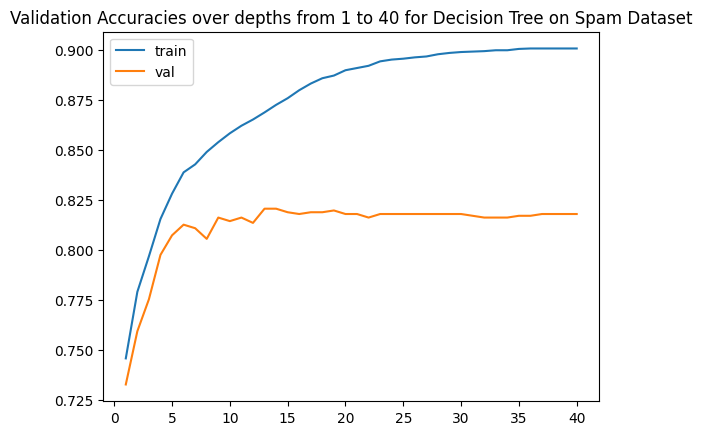

In [23]:
plt.plot(range(1, 41), train, label= 'train')
plt.plot(range(1, 41), val, label = 'val')
plt.title("Validation Accuracies over depths from 1 to 40 for Decision Tree on Spam Dataset")
plt.legend()
plt.show()

In [24]:
# Decision Tree for Spam Data
maxdepth = 14
clf = DecisionTree(max_depth=maxdepth, feature_labels =features)
clf.fit(X_train_spam, y_train_spam)
train_pred = clf.predict(X_train_spam)
train_acc = accuracy(train_pred, y_train_spam)
val_pred = clf.predict(X_val_spam)
val_acc = accuracy(val_pred, y_val_spam)
print(f"Decison Tree on Spam Data with Depth = {maxdepth} has train accuracy = {train_acc} and val accuracy ={val_acc}")


Decison Tree on Spam Data with Depth = 14 has train accuracy = 0.8725294248278925 and val accuracy =0.8206039076376554


In [46]:
# Random Forest for Spam Data
np.random.seed(42)
rfr = RandomForest(maxdepth=14, n=25, features=features, sample_size=3000, m=6)
rfr.fit(X_train_spam, y_train_spam)
train_pred = rfr.predict(X_train_spam)
train_acc = accuracy(train_pred, y_train_spam)
val_pred = rfr.predict(X_val_spam)
val_acc = accuracy(val_pred, y_val_spam)
print(f"Random Forest on Spam Data has train accuracy = {train_acc} and val accuracy ={val_acc}")

Random Forest on Spam Data has train accuracy = 0.8039085054408173 and val accuracy =0.7939609236234458


## Titanic Dataset

In [49]:
dataset ='titanic'
X_titanic, y_titanic, titanic_test, features, class_names = LoadData(dataset)
X_train_titanic, X_val_titanic, y_train_titanic, y_val_titanic = train_test_split(X, y, test_size = 0.2, random_state=42)

<ipython-input-3-76dea0ddda04>:44: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
<ipython-input-3-76dea0ddda04>:46: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


In [13]:
# Decision Tree with depth=3 for Titanic Data
clf = DecisionTree(max_depth=3, feature_labels =features)
clf.fit(X_train_titanic, y_train_titanic)

[b'female' < 1e-05: [b'pclass' < 1.00001: [b'age' < 53.638896666666675: 0 (95) | 0 (18)] | [b'age' < 33.074056666666664: 0 (325) | 0 (87)]] | [b'pclass' < 2.11111: [b'parch' < 1e-05: 1 (102) | 1 (53)] | [b'fare' < 27.85000333333333: 1 (115) | 0 (12)]]]

In [42]:
# Decision Tree for Titanic Data
maxdepth = 6
clf = DecisionTree(max_depth=maxdepth, feature_labels =features)
clf.fit(X_train_titanic, y_train_titanic)
train_pred = clf.predict(X_train_titanic)
train_acc = accuracy(train_pred, y_train_titanic)
val_pred = clf.predict(X_val_titanic)
val_acc = accuracy(val_pred, y_val_titanic)
print(f"Decison Tree on Titanic Data with Depth = {maxdepth} has train accuracy = {train_acc} and val accuracy ={val_acc}")

Decison Tree on Titanic Data with Depth = 6 has train accuracy = 0.8302354399008675 and val accuracy =0.8267326732673267


In [44]:
# Random Forest for Titanic Data
np.random.seed(42)
rfr = RandomForest(maxdepth=6, n=80, features=features, sample_size=700, m=4)
rfr.fit(X_train_titanic, y_train_titanic)
train_pred = rfr.predict(X_train_titanic)
train_acc = accuracy(train_pred, y_train_titanic)
val_pred = rfr.predict(X_val_titanic)
val_acc = accuracy(val_pred, y_val_titanic)
train_acc
print(f"Random Forest on Titanic Data has train accuracy = {train_acc} and val accuracy ={val_acc}")

Random Forest on Titanic Data has train accuracy = 0.8178438661710037 and val accuracy =0.7920792079207921


## Kaggle Submission

In [52]:
import pandas as pd
import numpy as np

# Usage: results_to_csv(clf.predict(X_test))
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv(f"{name}_submission.csv", index_label='Id')

Spam Best Classifier

In [64]:
# Best decision tree with depth = 14
clf = DecisionTree(max_depth=14, feature_labels =features)
clf.fit(X_spam, y_spam)
y_pred = clf.predict(spam_test)
y_pred.shape

(5400,)

In [65]:
results_to_csv(y_pred, 'spam')

Titanic Best Classifier

In [63]:
# Best decision tree with deoth = 6
clf = DecisionTree(max_depth=6, feature_labels =features)
clf.fit(X_titanic, y_titanic)
y_pred = clf.predict(titanic_test)
y_pred.shape

(300,)

In [62]:
results_to_csv(y_pred, 'titanic')